In [1]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.7427, 0.6721, 0.8432],
        [0.6370, 0.5320, 0.8856],
        [0.4872, 0.9254, 0.1936],
        [0.9545, 0.2096, 0.6531],
        [0.2080, 0.2058, 0.8525]])


In [2]:
torch.cuda.is_available()

# Create a tensor on the CPU
x = torch.randn(3, 3)

# Move the tensor to the GPU
device = torch.device("cuda")
print(type(device))
x = x.to(device)
print(x)

<class 'torch.device'>
tensor([[ 0.0583,  0.5781, -1.7725],
        [-0.8800,  0.3745,  1.1885],
        [ 1.0820, -0.3239, -1.6702]], device='cuda:0')


### Datasets & DataLoaders

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

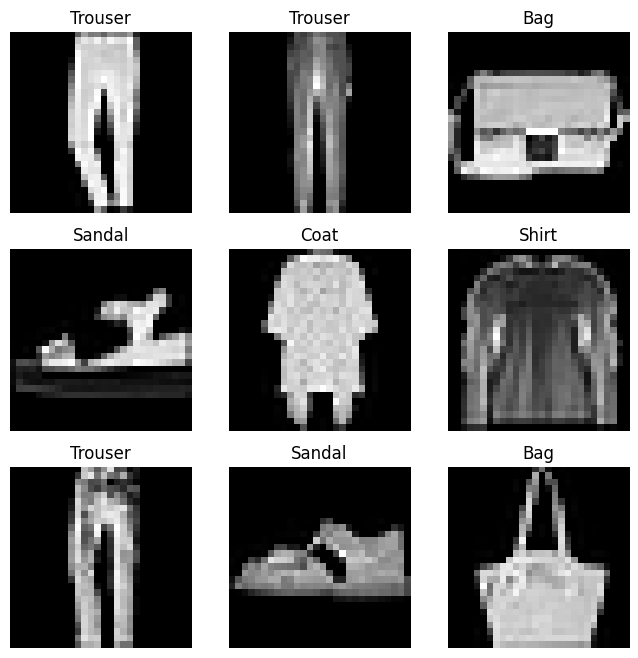

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Custom Dataset

In [6]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Samplers

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])
Label: 8


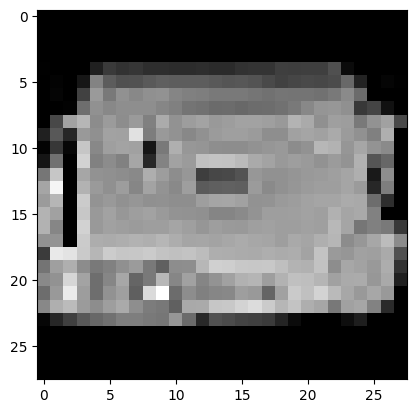

In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
print(f"Label: {label}")
plt.imshow(img, cmap="gray")
plt.show()


### Transforms

- ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

- Lambda transforms apply any user-defined lambda function. Here, we define a function to turn the integer into a one-hot encoded tensor. It first creates a zero tensor of size 10 (the number of labels in our dataset) and calls scatter_ which assigns a value=1 on the index as given by the label y.

In [9]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

print(ds[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000

### Build the Neural Network

In [38]:
import os
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timeit

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__() # By using super().__init__() , Network's __init__ will be same as its parent __init__.
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

# by calling this model, actually nn.Module will handle this call and track changes.

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [14]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
print(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

tensor([[[0.5056, 0.9503, 0.7280, 0.1587, 0.5423, 0.6521, 0.3882, 0.4237,
          0.5070, 0.9809, 0.5305, 0.9298, 0.0209, 0.7448, 0.8442, 0.7481,
          0.7727, 0.2930, 0.0386, 0.1299, 0.5376, 0.2749, 0.7698, 0.2669,
          0.3323, 0.9926, 0.5586, 0.7593],
         [0.9944, 0.8925, 0.1947, 0.6155, 0.1350, 0.6261, 0.2842, 0.0360,
          0.5505, 0.5023, 0.7633, 0.0287, 0.6074, 0.4994, 0.2566, 0.2006,
          0.9309, 0.5445, 0.6997, 0.8781, 0.6508, 0.3396, 0.4373, 0.5556,
          0.9266, 0.2453, 0.2746, 0.1882],
         [0.9703, 0.0437, 0.5235, 0.2729, 0.2465, 0.1710, 0.7155, 0.4955,
          0.5385, 0.3984, 0.0848, 0.1314, 0.1399, 0.8138, 0.4204, 0.8336,
          0.7401, 0.4114, 0.5483, 0.5812, 0.3319, 0.4795, 0.7492, 0.6385,
          0.1196, 0.5876, 0.2971, 0.9160],
         [0.8041, 0.3245, 0.0604, 0.6367, 0.9885, 0.4748, 0.3883, 0.0543,
          0.8180, 0.4848, 0.3164, 0.2809, 0.1360, 0.7592, 0.2628, 0.2201,
          0.4543, 0.0311, 0.3437, 0.8763, 0.8152, 0.6743,

### Test Outputs

In [15]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


In [16]:
flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

torch.Size([3, 784])


In [17]:
layer1 = nn.Linear(in_features=28*28, out_features=20)
print(f'Size weight: {layer1.weight.size()}')
print(f'Size bias: {layer1.bias.size()}')

hidden1 = layer1(flat_image)
print(f'Size hidden1 output: {hidden1.size()}')

print(f"Before ReLU: {hidden1}\n Size: {hidden1.size()}")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}\n Size: {hidden1.size()}\n\n")

layer2 = nn.Linear(in_features=20, out_features=5)

hidden2 = layer2(hidden1)
print(f'Size hidden2 output: {hidden2.size()}')

print(f"Before ReLU: {hidden2}\n Size: {hidden2.size()}")
hidden2 = nn.ReLU()(hidden2)
print(f"After ReLU: {hidden2}\n Size: {hidden2.size()}")

Size weight: torch.Size([20, 784])
Size bias: torch.Size([20])
Size hidden1 output: torch.Size([3, 20])
Before ReLU: tensor([[-0.5031, -0.2107,  0.0988,  0.1570, -0.1464, -0.7507,  0.1217, -0.3432,
          0.0619, -0.2923, -0.6108, -0.4006,  0.2286,  0.5563, -0.2752, -0.0596,
          0.0090,  0.7896,  0.2072, -0.2662],
        [-0.4811,  0.0079,  0.1861,  0.0732,  0.0976, -0.6339,  0.5069, -0.5402,
          0.2426, -0.1390, -0.0913, -0.0633,  0.3260,  0.0096, -0.1194, -0.1931,
         -0.0661,  0.4451,  0.1235, -0.5931],
        [-0.4399,  0.0902,  0.2226,  0.2330,  0.0615, -0.6486,  0.1035, -0.3097,
          0.2909,  0.0337, -0.3540, -0.1220,  0.4993,  0.5779, -0.0353, -0.5439,
          0.2574,  0.5870, -0.0670, -0.6898]], grad_fn=<AddmmBackward0>)
 Size: torch.Size([3, 20])
After ReLU: tensor([[0.0000, 0.0000, 0.0988, 0.1570, 0.0000, 0.0000, 0.1217, 0.0000, 0.0619,
         0.0000, 0.0000, 0.0000, 0.2286, 0.5563, 0.0000, 0.0000, 0.0090, 0.7896,
         0.2072, 0.0000],
     

In [18]:
x = flat_image.to('cuda')
# Forward pass and print the size at each layer
print("Input size:", flat_image.size())
for layer in model.linear_relu_stack:
    x = layer(x)
    print(f"Output size after {layer.__class__.__name__}: {x.size()}")


Input size: torch.Size([3, 784])
Output size after Linear: torch.Size([3, 512])
Output size after ReLU: torch.Size([3, 512])
Output size after Linear: torch.Size([3, 512])
Output size after ReLU: torch.Size([3, 512])
Output size after Linear: torch.Size([3, 10])


In [19]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[ 0.0270, -0.0104,  0.0328,  ..., -0.0113, -0.0296, -0.0304],
        [ 0.0238, -0.0188,  0.0226,  ..., -0.0056, -0.0140, -0.0240]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0238,  0.0215], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0197, -0.0395, -0.0435,  ..., -0.0306, -0.0394,  0.0175],
        [ 0.0296,  0.0218,  0.0338,  ..., -0.0159,  0.0394,  0.0205]],
       device='cuda:0', grad_fn=<Sl

In [20]:
x = flat_image.to('cuda')
logits = model(x)

softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

### Automatic Differentiation with torch.autograd

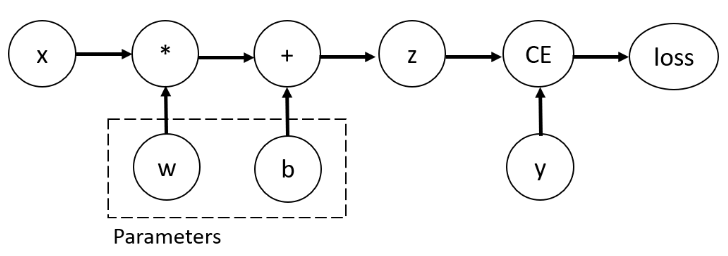

In [21]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5,3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(x)
print(w)
print(b)
print(z)

tensor([1., 1., 1., 1., 1.])
tensor([[-0.0907,  0.5950,  1.8360],
        [ 0.5227,  0.2918,  2.1477],
        [ 0.4998, -1.1659, -0.0337],
        [-0.1024,  0.3999, -1.0319],
        [-1.1986, -0.3346,  1.3124]], requires_grad=True)
tensor([ 0.1569, -1.6328, -0.3733], requires_grad=True)
tensor([-0.2122, -1.8466,  3.8571], grad_fn=<AddBackward0>)


In [22]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

Gradient function for z = <AddBackward0 object at 0x7b09f79b7700>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7b09f79b7640>


In [23]:
loss.backward()
print(w.grad)
print(b.grad)


tensor([[0.1490, 0.0454, 0.3264],
        [0.1490, 0.0454, 0.3264],
        [0.1490, 0.0454, 0.3264],
        [0.1490, 0.0454, 0.3264],
        [0.1490, 0.0454, 0.3264]])
tensor([0.1490, 0.0454, 0.3264])


In [24]:
import torch

# Create some synthetic data
x = torch.tensor([1.0, 2.0, 3.0, 4.0])  # Input feature
y_true = torch.tensor([2.0, 4.0, 6.0, 8.0])  # True target values

# Define model parameters (weights and bias)
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# Forward pass
y_pred = w * x + b

# Calculate loss (Mean Squared Error)
loss = torch.mean((y_pred - y_true)**2)
print(loss)
# Backward pass (Autograd computes gradients automatically)
loss.backward()

# Gradients are computed
print(torch.mean(((y_pred - y_true)*x*2)))
print(torch.mean(((y_pred - y_true)*2)))
loss_fn = nn.MSELoss()
print("Gradient of w:", w.grad)
print(b.grad)

tensor(7.5000, grad_fn=<MeanBackward0>)
tensor(-15., grad_fn=<MeanBackward0>)
tensor(-5., grad_fn=<MeanBackward0>)
Gradient of w: tensor(-15.)
tensor(-5.)


#### Aprofundando conhecimentos em autograd/backprop

http://blog.ezyang.com/2019/05/pytorch-internals/

https://pytorch.org/blog/overview-of-pytorch-autograd-engine/

https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html

https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf


### Optimizing Model Parameters

In [84]:
train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
model.to(device)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [92]:
learning_rate = 1e-3
batch_size = 64
epochs = 20

In [85]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):

    # start timer
    loop_time = timeit.default_timer()

    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

   # Print the memory usage after the loop
    allocated_after = torch.cuda.memory_allocated(device) / 1024**3  # in GB
    reserved_after = torch.cuda.memory_reserved(device) / 1024**3  # in GB
    
    print(f"Epoch {t+1} - After Training:")
    print(f"Allocated memory: {allocated_after:.2f} GB")
    print(f"Reserved memory: {reserved_after:.2f} GB")
    
    # Optionally, you can print GPU utilization here using nvidia-smi or other PyTorch methods
    gpu_utilization = torch.cuda.max_memory_allocated(device) / 1024**3  # in GB
    print(f"Maximum GPU Memory Usage in Epoch {t+1}: {gpu_utilization:.2f} GB\n")
    print('Time {}'.format(np.round((timeit.default_timer() - loop_time),2)))   

    torch.cuda.empty_cache()
    
print("Done!")

Epoch 1
-------------------------------
loss: 0.209116  [   64/60000]
loss: 0.279482  [ 6464/60000]
loss: 0.170093  [12864/60000]
loss: 0.301132  [19264/60000]
loss: 0.255625  [25664/60000]
loss: 0.273720  [32064/60000]
loss: 0.218476  [38464/60000]
loss: 0.345895  [44864/60000]
loss: 0.325817  [51264/60000]
loss: 0.324989  [57664/60000]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.351380 

Epoch 1 - After Training:
Allocated memory: 0.05 GB
Reserved memory: 0.05 GB
Maximum GPU Memory Usage in Epoch 1: 0.05 GB

Time 5.62
Epoch 2
-------------------------------
loss: 0.198335  [   64/60000]
loss: 0.271825  [ 6464/60000]
loss: 0.163986  [12864/60000]
loss: 0.291893  [19264/60000]
loss: 0.246597  [25664/60000]
loss: 0.266762  [32064/60000]
loss: 0.211393  [38464/60000]
loss: 0.337293  [44864/60000]
loss: 0.320851  [51264/60000]
loss: 0.326892  [57664/60000]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.350015 

Epoch 2 - After Training:
Allocated memory: 0.05 GB
Reserved memory: 0.05 GB
Maximu

### Save and Load

In [29]:
torch.save(model.state_dict(), 'model_weights.pth')

In [30]:
import torchvision.models as models
model = NeuralNetwork()
model.to(device) # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [91]:
# nn.BatchNorm1d

x = torch.rand(100, 16, 784)  # here imgs are flattened from 28x28

layer = nn.BatchNorm1d(16)  # batch norm is done on channels
out = layer(x)
print(x)
print(out)
print(layer.running_mean)
print(layer.running_var)

tensor([[[0.6620, 0.5844, 0.5096,  ..., 0.3195, 0.0515, 0.9660],
         [0.3784, 0.5876, 0.0306,  ..., 0.0272, 0.2511, 0.4970],
         [0.0796, 0.6435, 0.6039,  ..., 0.4245, 0.1025, 0.4398],
         ...,
         [0.1778, 0.9871, 0.6966,  ..., 0.4566, 0.9703, 0.5987],
         [0.6116, 0.1819, 0.2378,  ..., 0.4266, 0.7019, 0.1716],
         [0.2804, 0.2065, 0.7712,  ..., 0.4381, 0.6182, 0.9823]],

        [[0.0642, 0.6994, 0.6014,  ..., 0.9374, 0.6008, 0.0429],
         [0.3427, 0.9644, 0.2756,  ..., 0.1075, 0.2941, 0.3622],
         [0.2991, 0.6931, 0.0535,  ..., 0.5465, 0.4411, 0.3666],
         ...,
         [0.1730, 0.2013, 0.1712,  ..., 0.3696, 0.0597, 0.7212],
         [0.2426, 0.1617, 0.6943,  ..., 0.9656, 0.3871, 0.0075],
         [0.7950, 0.4569, 0.2348,  ..., 0.3168, 0.1802, 0.1766]],

        [[0.6411, 0.8230, 0.6128,  ..., 0.6406, 0.0445, 0.6278],
         [0.0519, 0.2135, 0.8272,  ..., 0.1435, 0.6723, 0.0728],
         [0.9684, 0.3156, 0.7233,  ..., 0.4573, 0.6275, 0.